[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomDefendLine-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-26 23:07:51,653] Making new env: ppaquette/DoomDefendLine-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

1.0 False


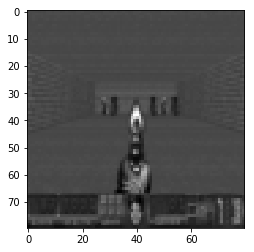

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-26 23:07:52,565] Making new env: ppaquette/DoomDefendLine-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[3 0 3 0 0 0 0]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 100 ms, sys: 12 ms, total: 112 ms
Wall time: 161 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-26 23:08:22,981] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:08:22,990] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-26 23:08:23,234] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.16263.video000000.mp4


Episode finished after 123 timesteps with reward=8.0


[2017-06-26 23:08:25,998] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.16263.video000001.mp4


Episode finished after 62 timesteps with reward=3.0
Episode finished after 127 timesteps with reward=10.0
Episode finished after 167 timesteps with reward=10.0
Episode finished after 39 timesteps with reward=0.0
Episode finished after 88 timesteps with reward=4.0
Episode finished after 57 timesteps with reward=2.0


[2017-06-26 23:08:34,804] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.16263.video000008.mp4


Episode finished after 56 timesteps with reward=2.0
Episode finished after 80 timesteps with reward=6.0


[2017-06-26 23:08:38,002] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 100 timesteps with reward=4.0


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:02<07:33,  4.39it/s]

iter=10	epsilon=0.954	reward/step=0.05455


  1%|          | 21/2000 [00:04<07:27,  4.42it/s]

iter=20	epsilon=0.910	reward/step=0.04762


  2%|▏         | 31/2000 [00:07<07:21,  4.46it/s]

iter=30	epsilon=0.868	reward/step=0.05161


  2%|▏         | 41/2000 [00:09<07:39,  4.26it/s]

iter=40	epsilon=0.828	reward/step=0.05122


  2%|▏         | 49/2000 [00:11<08:09,  3.99it/s][2017-06-26 23:08:49,921] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:08:49,929] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=0.05294
Episode finished after 80 timesteps with reward=6.0
Episode finished after 128 timesteps with reward=9.0
Episode finished after 115 timesteps with reward=9.0
Episode finished after 113 timesteps with reward=11.0


[2017-06-26 23:08:58,199] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:20<1:29:25,  2.75s/it]

Episode finished after 136 timesteps with reward=10.0


  3%|▎         | 60/2000 [00:22<10:57,  2.95it/s]  

iter=60	epsilon=0.754	reward/step=0.05410


  4%|▎         | 70/2000 [00:25<08:24,  3.83it/s]

iter=70	epsilon=0.719	reward/step=0.05070


  4%|▍         | 80/2000 [00:27<08:20,  3.83it/s]

iter=80	epsilon=0.687	reward/step=0.05309


  4%|▍         | 90/2000 [00:30<08:34,  3.71it/s]

iter=90	epsilon=0.656	reward/step=0.05824


  5%|▍         | 99/2000 [00:32<08:09,  3.88it/s][2017-06-26 23:09:10,965] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:09:10,970] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=0.06139
Episode finished after 213 timesteps with reward=18.0
Episode finished after 74 timesteps with reward=3.0
Episode finished after 161 timesteps with reward=17.0
Episode finished after 81 timesteps with reward=3.0


[2017-06-26 23:09:19,825] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [00:41<1:32:51,  2.93s/it]

Episode finished after 103 timesteps with reward=8.0


  6%|▌         | 110/2000 [00:44<11:07,  2.83it/s]  

iter=110	epsilon=0.598	reward/step=0.06306


  6%|▌         | 120/2000 [00:47<08:51,  3.54it/s]

iter=120	epsilon=0.571	reward/step=0.06529


  6%|▋         | 130/2000 [00:49<08:42,  3.58it/s]

iter=130	epsilon=0.546	reward/step=0.06412


  7%|▋         | 140/2000 [00:52<08:56,  3.47it/s]

iter=140	epsilon=0.522	reward/step=0.06170


  7%|▋         | 149/2000 [00:54<08:31,  3.62it/s][2017-06-26 23:09:33,321] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:09:33,326] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=0.06358
Episode finished after 176 timesteps with reward=17.0
Episode finished after 112 timesteps with reward=11.0
Episode finished after 130 timesteps with reward=9.0
Episode finished after 141 timesteps with reward=13.0


[2017-06-26 23:09:42,428] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [01:04<1:33:23,  3.03s/it]

Episode finished after 86 timesteps with reward=7.0


  8%|▊         | 160/2000 [01:07<13:00,  2.36it/s]  

iter=160	epsilon=0.477	reward/step=0.06335


  8%|▊         | 170/2000 [01:10<09:11,  3.32it/s]

iter=170	epsilon=0.456	reward/step=0.06257


  9%|▉         | 180/2000 [01:13<08:50,  3.43it/s]

iter=180	epsilon=0.436	reward/step=0.06298


 10%|▉         | 190/2000 [01:16<09:09,  3.29it/s]

iter=190	epsilon=0.417	reward/step=0.06283


 10%|▉         | 199/2000 [01:18<08:43,  3.44it/s][2017-06-26 23:09:57,289] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:09:57,294] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=0.06169
Episode finished after 76 timesteps with reward=7.0
Episode finished after 101 timesteps with reward=10.0
Episode finished after 89 timesteps with reward=5.0
Episode finished after 71 timesteps with reward=5.0


[2017-06-26 23:10:03,039] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [01:24<1:00:58,  2.03s/it]

Episode finished after 71 timesteps with reward=4.0


 10%|█         | 210/2000 [01:27<10:29,  2.84it/s]  

iter=210	epsilon=0.382	reward/step=0.06066


 11%|█         | 220/2000 [01:31<09:40,  3.06it/s]

iter=220	epsilon=0.366	reward/step=0.06063


 12%|█▏        | 230/2000 [01:34<09:49,  3.00it/s]

iter=230	epsilon=0.351	reward/step=0.06017


 12%|█▏        | 240/2000 [01:37<09:57,  2.95it/s]

iter=240	epsilon=0.336	reward/step=0.05934


 12%|█▏        | 249/2000 [01:40<09:38,  3.03it/s][2017-06-26 23:10:18,852] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:10:18,860] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=0.05817
Episode finished after 45 timesteps with reward=1.0
Episode finished after 102 timesteps with reward=5.0
Episode finished after 151 timesteps with reward=9.0
Episode finished after 120 timesteps with reward=7.0


[2017-06-26 23:10:25,359] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [01:47<1:06:59,  2.30s/it]

Episode finished after 65 timesteps with reward=4.0


 13%|█▎        | 260/2000 [01:50<11:55,  2.43it/s]  

iter=260	epsilon=0.309	reward/step=0.05747


 14%|█▎        | 270/2000 [01:54<10:19,  2.79it/s]

iter=270	epsilon=0.296	reward/step=0.05683


 14%|█▍        | 280/2000 [01:57<10:20,  2.77it/s]

iter=280	epsilon=0.284	reward/step=0.05694


 14%|█▍        | 290/2000 [02:01<10:21,  2.75it/s]

iter=290	epsilon=0.273	reward/step=0.05636


 15%|█▍        | 299/2000 [02:04<09:56,  2.85it/s][2017-06-26 23:10:42,842] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:10:42,846] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=0.05567
Episode finished after 83 timesteps with reward=5.0
Episode finished after 78 timesteps with reward=6.0
Episode finished after 77 timesteps with reward=3.0
Episode finished after 64 timesteps with reward=3.0


[2017-06-26 23:10:48,225] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [02:10<56:11,  1.98s/it]

Episode finished after 89 timesteps with reward=5.0


 16%|█▌        | 310/2000 [02:13<11:05,  2.54it/s]

iter=310	epsilon=0.252	reward/step=0.05533


 16%|█▌        | 320/2000 [02:17<10:13,  2.74it/s]

iter=320	epsilon=0.242	reward/step=0.05600


 16%|█▋        | 330/2000 [02:20<09:39,  2.88it/s]

iter=330	epsilon=0.232	reward/step=0.05600


 17%|█▋        | 340/2000 [02:23<09:45,  2.84it/s]

iter=340	epsilon=0.224	reward/step=0.05567


 17%|█▋        | 349/2000 [02:26<09:18,  2.96it/s][2017-06-26 23:11:05,224] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:11:05,229] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=0.05433
Episode finished after 70 timesteps with reward=2.0
Episode finished after 92 timesteps with reward=4.0
Episode finished after 149 timesteps with reward=12.0
Episode finished after 29 timesteps with reward=0.0


[2017-06-26 23:11:11,346] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [02:33<1:00:14,  2.19s/it]

Episode finished after 105 timesteps with reward=5.0


 18%|█▊        | 360/2000 [02:36<11:21,  2.41it/s]  

iter=360	epsilon=0.207	reward/step=0.05400


 18%|█▊        | 370/2000 [02:40<09:37,  2.82it/s]

iter=370	epsilon=0.199	reward/step=0.05433


 19%|█▉        | 380/2000 [02:43<09:31,  2.84it/s]

iter=380	epsilon=0.192	reward/step=0.05267


 20%|█▉        | 390/2000 [02:47<09:38,  2.78it/s]

iter=390	epsilon=0.185	reward/step=0.05167


 20%|█▉        | 399/2000 [02:50<09:10,  2.91it/s][2017-06-26 23:11:28,750] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:11:28,754] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=0.05033
Episode finished after 88 timesteps with reward=3.0
Episode finished after 77 timesteps with reward=4.0
Episode finished after 67 timesteps with reward=3.0
Episode finished after 149 timesteps with reward=11.0


[2017-06-26 23:11:35,562] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [02:57<1:04:08,  2.41s/it]

Episode finished after 111 timesteps with reward=6.0


 20%|██        | 410/2000 [03:00<10:52,  2.44it/s]  

iter=410	epsilon=0.172	reward/step=0.04867


 21%|██        | 420/2000 [03:04<09:18,  2.83it/s]

iter=420	epsilon=0.166	reward/step=0.04667


 22%|██▏       | 430/2000 [03:07<09:28,  2.76it/s]

iter=430	epsilon=0.161	reward/step=0.04700


 22%|██▏       | 440/2000 [03:11<09:21,  2.78it/s]

iter=440	epsilon=0.155	reward/step=0.04767


 22%|██▏       | 449/2000 [03:14<08:51,  2.92it/s][2017-06-26 23:11:52,764] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:11:52,769] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=0.04633
Episode finished after 69 timesteps with reward=4.0
Episode finished after 49 timesteps with reward=3.0
Episode finished after 112 timesteps with reward=6.0
Episode finished after 77 timesteps with reward=7.0


[2017-06-26 23:11:57,995] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [03:19<49:47,  1.93s/it]

Episode finished after 76 timesteps with reward=4.0


 23%|██▎       | 460/2000 [03:23<10:35,  2.42it/s]

iter=460	epsilon=0.145	reward/step=0.04533


 24%|██▎       | 470/2000 [03:27<09:16,  2.75it/s]

iter=470	epsilon=0.141	reward/step=0.04633


 24%|██▍       | 480/2000 [03:30<08:57,  2.83it/s]

iter=480	epsilon=0.136	reward/step=0.04567


 24%|██▍       | 490/2000 [03:33<08:48,  2.86it/s]

iter=490	epsilon=0.132	reward/step=0.04467


 25%|██▍       | 499/2000 [03:37<08:43,  2.87it/s][2017-06-26 23:12:15,499] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:12:15,503] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=0.04567
Episode finished after 68 timesteps with reward=2.0
Episode finished after 151 timesteps with reward=15.0
Episode finished after 141 timesteps with reward=7.0
Episode finished after 91 timesteps with reward=6.0


[2017-06-26 23:12:22,784] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [03:44<1:03:55,  2.56s/it]

Episode finished after 87 timesteps with reward=5.0


 26%|██▌       | 510/2000 [03:48<10:16,  2.42it/s]  

iter=510	epsilon=0.124	reward/step=0.04433


 26%|██▌       | 520/2000 [03:51<08:44,  2.82it/s]

iter=520	epsilon=0.121	reward/step=0.04400


 26%|██▋       | 530/2000 [03:55<08:52,  2.76it/s]

iter=530	epsilon=0.117	reward/step=0.04467


 27%|██▋       | 540/2000 [03:58<08:38,  2.81it/s]

iter=540	epsilon=0.114	reward/step=0.04467


 27%|██▋       | 549/2000 [04:01<08:08,  2.97it/s][2017-06-26 23:12:39,858] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:12:39,863] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=0.04467
Episode finished after 99 timesteps with reward=6.0
Episode finished after 102 timesteps with reward=5.0
Episode finished after 97 timesteps with reward=5.0
Episode finished after 132 timesteps with reward=10.0


[2017-06-26 23:12:46,589] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [04:08<57:17,  2.37s/it]

Episode finished after 62 timesteps with reward=2.0


 28%|██▊       | 560/2000 [04:12<10:06,  2.38it/s]

iter=560	epsilon=0.108	reward/step=0.04467


 28%|██▊       | 570/2000 [04:15<08:34,  2.78it/s]

iter=570	epsilon=0.105	reward/step=0.04567


 29%|██▉       | 580/2000 [04:19<08:37,  2.74it/s]

iter=580	epsilon=0.102	reward/step=0.04567


 30%|██▉       | 590/2000 [04:22<08:11,  2.87it/s]

iter=590	epsilon=0.100	reward/step=0.04500


 30%|██▉       | 599/2000 [04:25<07:50,  2.98it/s][2017-06-26 23:13:03,974] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:13:03,979] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=0.04567
Episode finished after 144 timesteps with reward=8.0
Episode finished after 44 timesteps with reward=1.0
Episode finished after 82 timesteps with reward=3.0
Episode finished after 47 timesteps with reward=1.0


[2017-06-26 23:13:09,065] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [04:31<43:52,  1.88s/it]

Episode finished after 61 timesteps with reward=1.0


 30%|███       | 610/2000 [04:34<09:08,  2.53it/s]

iter=610	epsilon=0.095	reward/step=0.04600


 31%|███       | 620/2000 [04:37<08:09,  2.82it/s]

iter=620	epsilon=0.093	reward/step=0.04567


 32%|███▏      | 630/2000 [04:41<08:16,  2.76it/s]

iter=630	epsilon=0.091	reward/step=0.04600


 32%|███▏      | 640/2000 [04:44<07:57,  2.85it/s]

iter=640	epsilon=0.089	reward/step=0.04600


 32%|███▏      | 649/2000 [04:47<07:45,  2.91it/s][2017-06-26 23:13:26,295] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:13:26,300] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=0.04667
Episode finished after 111 timesteps with reward=7.0
Episode finished after 46 timesteps with reward=1.0
Episode finished after 97 timesteps with reward=7.0
Episode finished after 104 timesteps with reward=13.0


[2017-06-26 23:13:31,951] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [04:53<46:19,  2.06s/it]

Episode finished after 52 timesteps with reward=2.0


 33%|███▎      | 660/2000 [04:57<09:02,  2.47it/s]

iter=660	epsilon=0.085	reward/step=0.04700


 34%|███▎      | 670/2000 [05:00<07:54,  2.80it/s]

iter=670	epsilon=0.083	reward/step=0.04733


 34%|███▍      | 680/2000 [05:04<07:45,  2.83it/s]

iter=680	epsilon=0.082	reward/step=0.04900


 34%|███▍      | 690/2000 [05:07<07:43,  2.83it/s]

iter=690	epsilon=0.080	reward/step=0.04967


 35%|███▍      | 699/2000 [05:10<07:17,  2.98it/s][2017-06-26 23:13:49,230] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:13:49,234] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=0.04867
Episode finished after 65 timesteps with reward=3.0
Episode finished after 99 timesteps with reward=6.0
Episode finished after 46 timesteps with reward=2.0
Episode finished after 81 timesteps with reward=4.0


[2017-06-26 23:13:54,363] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [05:16<41:05,  1.90s/it]

Episode finished after 85 timesteps with reward=6.0


 36%|███▌      | 710/2000 [05:19<08:36,  2.50it/s]

iter=710	epsilon=0.077	reward/step=0.04933


 36%|███▌      | 720/2000 [05:23<07:27,  2.86it/s]

iter=720	epsilon=0.076	reward/step=0.04933


 36%|███▋      | 730/2000 [05:26<07:25,  2.85it/s]

iter=730	epsilon=0.075	reward/step=0.04933


 37%|███▋      | 740/2000 [05:30<07:29,  2.81it/s]

iter=740	epsilon=0.073	reward/step=0.04967


 37%|███▋      | 749/2000 [05:33<07:03,  2.96it/s][2017-06-26 23:14:11,500] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:14:11,505] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=0.04900
Episode finished after 133 timesteps with reward=8.0
Episode finished after 42 timesteps with reward=1.0
Episode finished after 102 timesteps with reward=5.0
Episode finished after 79 timesteps with reward=6.0


[2017-06-26 23:14:16,818] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [05:38<40:36,  1.95s/it]

Episode finished after 36 timesteps with reward=-1.0


 38%|███▊      | 760/2000 [05:42<08:21,  2.47it/s]

iter=760	epsilon=0.071	reward/step=0.04967


 38%|███▊      | 770/2000 [05:45<07:12,  2.85it/s]

iter=770	epsilon=0.070	reward/step=0.04800


 39%|███▉      | 780/2000 [05:49<07:06,  2.86it/s]

iter=780	epsilon=0.069	reward/step=0.04733


 40%|███▉      | 790/2000 [05:52<07:14,  2.78it/s]

iter=790	epsilon=0.068	reward/step=0.04933


 40%|███▉      | 799/2000 [05:55<06:46,  2.95it/s][2017-06-26 23:14:34,061] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:14:34,066] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=0.04867
Episode finished after 112 timesteps with reward=7.0
Episode finished after 53 timesteps with reward=2.0
Episode finished after 62 timesteps with reward=1.0
Episode finished after 141 timesteps with reward=7.0


[2017-06-26 23:14:40,214] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [06:02<44:05,  2.20s/it]

Episode finished after 89 timesteps with reward=5.0


 40%|████      | 810/2000 [06:05<08:00,  2.48it/s]

iter=810	epsilon=0.067	reward/step=0.05033


 41%|████      | 820/2000 [06:08<06:53,  2.85it/s]

iter=820	epsilon=0.066	reward/step=0.05100


 42%|████▏     | 830/2000 [06:12<06:57,  2.80it/s]

iter=830	epsilon=0.065	reward/step=0.05033


 42%|████▏     | 840/2000 [06:15<06:59,  2.76it/s]

iter=840	epsilon=0.064	reward/step=0.05167


 42%|████▏     | 849/2000 [06:18<06:40,  2.87it/s][2017-06-26 23:14:57,384] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:14:57,389] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=0.05300
Episode finished after 105 timesteps with reward=9.0
Episode finished after 86 timesteps with reward=4.0
Episode finished after 98 timesteps with reward=8.0
Episode finished after 144 timesteps with reward=9.0


[2017-06-26 23:15:04,326] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [06:26<46:55,  2.45s/it]

Episode finished after 73 timesteps with reward=4.0


 43%|████▎     | 860/2000 [06:30<08:11,  2.32it/s]

iter=860	epsilon=0.063	reward/step=0.05433


 44%|████▎     | 870/2000 [06:33<06:48,  2.77it/s]

iter=870	epsilon=0.062	reward/step=0.05433


 44%|████▍     | 880/2000 [06:36<06:40,  2.80it/s]

iter=880	epsilon=0.062	reward/step=0.05400


 44%|████▍     | 890/2000 [06:40<06:39,  2.78it/s]

iter=890	epsilon=0.061	reward/step=0.05533


 45%|████▍     | 899/2000 [06:43<06:25,  2.85it/s][2017-06-26 23:15:21,974] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:15:21,979] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=0.05567
Episode finished after 107 timesteps with reward=7.0
Episode finished after 110 timesteps with reward=9.0
Episode finished after 101 timesteps with reward=9.0
Episode finished after 107 timesteps with reward=11.0


[2017-06-26 23:15:29,967] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [06:51<50:43,  2.77s/it]

Episode finished after 140 timesteps with reward=10.0


 46%|████▌     | 910/2000 [06:55<07:51,  2.31it/s]

iter=910	epsilon=0.060	reward/step=0.05600


 46%|████▌     | 920/2000 [06:58<06:32,  2.75it/s]

iter=920	epsilon=0.060	reward/step=0.05633


 46%|████▋     | 930/2000 [07:02<06:25,  2.78it/s]

iter=930	epsilon=0.059	reward/step=0.05633


 47%|████▋     | 940/2000 [07:05<06:24,  2.76it/s]

iter=940	epsilon=0.059	reward/step=0.05733


 47%|████▋     | 949/2000 [07:08<05:59,  2.92it/s][2017-06-26 23:15:47,441] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:15:47,446] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=0.05733
Episode finished after 155 timesteps with reward=13.0
Episode finished after 201 timesteps with reward=15.0
Episode finished after 126 timesteps with reward=9.0
Episode finished after 118 timesteps with reward=10.0


[2017-06-26 23:15:57,463] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [07:19<58:53,  3.36s/it]

Episode finished after 107 timesteps with reward=7.0


 48%|████▊     | 960/2000 [07:23<07:54,  2.19it/s]

iter=960	epsilon=0.058	reward/step=0.05700


 48%|████▊     | 970/2000 [07:26<06:09,  2.79it/s]

iter=970	epsilon=0.057	reward/step=0.05733


 49%|████▉     | 980/2000 [07:30<06:06,  2.79it/s]

iter=980	epsilon=0.057	reward/step=0.05867


 50%|████▉     | 990/2000 [07:33<06:02,  2.79it/s]

iter=990	epsilon=0.057	reward/step=0.05833


 50%|████▉     | 999/2000 [07:36<05:43,  2.92it/s][2017-06-26 23:16:15,048] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:16:15,053] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=0.06000
Episode finished after 156 timesteps with reward=16.0
Episode finished after 141 timesteps with reward=11.0
Episode finished after 82 timesteps with reward=3.0
Episode finished after 75 timesteps with reward=9.0


[2017-06-26 23:16:22,945] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [07:44<45:30,  2.73s/it]

Episode finished after 104 timesteps with reward=9.0


 50%|█████     | 1010/2000 [07:48<07:04,  2.33it/s]

iter=1010	epsilon=0.056	reward/step=0.06033


 51%|█████     | 1020/2000 [07:51<05:51,  2.79it/s]

iter=1020	epsilon=0.056	reward/step=0.06233


 52%|█████▏    | 1030/2000 [07:55<05:49,  2.78it/s]

iter=1030	epsilon=0.056	reward/step=0.06367


 52%|█████▏    | 1040/2000 [07:58<05:43,  2.79it/s]

iter=1040	epsilon=0.055	reward/step=0.06300


 52%|█████▏    | 1049/2000 [08:01<05:35,  2.83it/s][2017-06-26 23:16:40,418] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:16:40,424] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=0.06567
Episode finished after 107 timesteps with reward=9.0
Episode finished after 149 timesteps with reward=12.0
Episode finished after 158 timesteps with reward=13.0
Episode finished after 218 timesteps with reward=21.0


[2017-06-26 23:16:52,095] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [08:14<1:01:20,  3.87s/it]

Episode finished after 208 timesteps with reward=21.0


 53%|█████▎    | 1060/2000 [08:17<07:12,  2.17it/s]  

iter=1060	epsilon=0.055	reward/step=0.06800


 54%|█████▎    | 1070/2000 [08:21<05:40,  2.73it/s]

iter=1070	epsilon=0.055	reward/step=0.07000


 54%|█████▍    | 1080/2000 [08:24<05:24,  2.83it/s]

iter=1080	epsilon=0.054	reward/step=0.07033


 55%|█████▍    | 1090/2000 [08:27<05:21,  2.83it/s]

iter=1090	epsilon=0.054	reward/step=0.06933


 55%|█████▍    | 1099/2000 [08:30<05:10,  2.90it/s][2017-06-26 23:17:09,427] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:17:09,431] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=0.07100
Episode finished after 156 timesteps with reward=13.0
Episode finished after 100 timesteps with reward=7.0
Episode finished after 95 timesteps with reward=8.0
Episode finished after 144 timesteps with reward=10.0


[2017-06-26 23:17:17,631] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [08:39<42:24,  2.83s/it]

Episode finished after 92 timesteps with reward=7.0


 56%|█████▌    | 1110/2000 [08:43<06:15,  2.37it/s]

iter=1110	epsilon=0.054	reward/step=0.07167


 56%|█████▌    | 1120/2000 [08:46<05:19,  2.75it/s]

iter=1120	epsilon=0.054	reward/step=0.07233


 56%|█████▋    | 1130/2000 [08:49<05:13,  2.78it/s]

iter=1130	epsilon=0.053	reward/step=0.07367


 57%|█████▋    | 1140/2000 [08:53<05:08,  2.78it/s]

iter=1140	epsilon=0.053	reward/step=0.07433


 57%|█████▋    | 1149/2000 [08:56<04:51,  2.92it/s][2017-06-26 23:17:35,007] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:17:35,012] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=0.07467
Episode finished after 116 timesteps with reward=9.0
Episode finished after 102 timesteps with reward=7.0
Episode finished after 67 timesteps with reward=5.0
Episode finished after 98 timesteps with reward=9.0


[2017-06-26 23:17:41,505] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [09:03<32:43,  2.31s/it]

Episode finished after 72 timesteps with reward=4.0


 58%|█████▊    | 1160/2000 [09:06<05:48,  2.41it/s]

iter=1160	epsilon=0.053	reward/step=0.07533


 58%|█████▊    | 1170/2000 [09:10<05:01,  2.75it/s]

iter=1170	epsilon=0.053	reward/step=0.07700


 59%|█████▉    | 1180/2000 [09:13<04:52,  2.81it/s]

iter=1180	epsilon=0.053	reward/step=0.07667


 60%|█████▉    | 1190/2000 [09:17<04:53,  2.76it/s]

iter=1190	epsilon=0.052	reward/step=0.07800


 60%|█████▉    | 1199/2000 [09:20<04:38,  2.87it/s][2017-06-26 23:17:58,958] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:17:58,963] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=0.07867
Episode finished after 104 timesteps with reward=6.0
Episode finished after 52 timesteps with reward=6.0
Episode finished after 138 timesteps with reward=16.0
Episode finished after 220 timesteps with reward=24.0


[2017-06-26 23:18:09,058] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [09:31<45:13,  3.39s/it]

Episode finished after 217 timesteps with reward=16.0


 60%|██████    | 1210/2000 [09:34<05:41,  2.31it/s]

iter=1210	epsilon=0.052	reward/step=0.07800


 61%|██████    | 1220/2000 [09:37<04:37,  2.81it/s]

iter=1220	epsilon=0.052	reward/step=0.07867


 62%|██████▏   | 1230/2000 [09:41<04:31,  2.83it/s]

iter=1230	epsilon=0.052	reward/step=0.07900


 62%|██████▏   | 1240/2000 [09:44<04:27,  2.84it/s]

iter=1240	epsilon=0.052	reward/step=0.07900


 62%|██████▏   | 1249/2000 [09:47<04:22,  2.86it/s][2017-06-26 23:18:26,215] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:18:26,220] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=0.08100
Episode finished after 143 timesteps with reward=17.0
Episode finished after 177 timesteps with reward=18.0
Episode finished after 102 timesteps with reward=10.0
Episode finished after 124 timesteps with reward=14.0


[2017-06-26 23:18:35,615] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [09:57<39:54,  3.19s/it]

Episode finished after 123 timesteps with reward=11.0


 63%|██████▎   | 1260/2000 [10:01<05:28,  2.25it/s]

iter=1260	epsilon=0.052	reward/step=0.08300


 64%|██████▎   | 1270/2000 [10:04<04:25,  2.75it/s]

iter=1270	epsilon=0.052	reward/step=0.08367


 64%|██████▍   | 1280/2000 [10:08<04:21,  2.75it/s]

iter=1280	epsilon=0.052	reward/step=0.08333


 64%|██████▍   | 1290/2000 [10:11<04:17,  2.76it/s]

iter=1290	epsilon=0.052	reward/step=0.08400


 65%|██████▍   | 1299/2000 [10:14<04:02,  2.89it/s][2017-06-26 23:18:53,173] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:18:53,178] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=0.08533
Episode finished after 163 timesteps with reward=17.0
Episode finished after 177 timesteps with reward=20.0
Episode finished after 123 timesteps with reward=12.0
Episode finished after 161 timesteps with reward=15.0


[2017-06-26 23:19:03,246] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [10:25<39:29,  3.39s/it]

Episode finished after 99 timesteps with reward=9.0


 66%|██████▌   | 1310/2000 [10:28<05:11,  2.22it/s]

iter=1310	epsilon=0.051	reward/step=0.08667


 66%|██████▌   | 1320/2000 [10:32<04:05,  2.77it/s]

iter=1320	epsilon=0.051	reward/step=0.08667


 66%|██████▋   | 1330/2000 [10:35<04:01,  2.78it/s]

iter=1330	epsilon=0.051	reward/step=0.08667


 67%|██████▋   | 1340/2000 [10:39<03:56,  2.79it/s]

iter=1340	epsilon=0.051	reward/step=0.08833


 67%|██████▋   | 1349/2000 [10:42<03:48,  2.85it/s][2017-06-26 23:19:20,755] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:19:20,760] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=0.08733
Episode finished after 169 timesteps with reward=20.0
Episode finished after 176 timesteps with reward=21.0
Episode finished after 74 timesteps with reward=8.0
Episode finished after 138 timesteps with reward=15.0


[2017-06-26 23:19:30,885] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [10:52<36:54,  3.41s/it]

Episode finished after 152 timesteps with reward=18.0


 68%|██████▊   | 1360/2000 [10:56<04:47,  2.23it/s]

iter=1360	epsilon=0.051	reward/step=0.08667


 68%|██████▊   | 1370/2000 [10:59<03:48,  2.75it/s]

iter=1370	epsilon=0.051	reward/step=0.08667


 69%|██████▉   | 1380/2000 [11:03<03:45,  2.75it/s]

iter=1380	epsilon=0.051	reward/step=0.08900


 70%|██████▉   | 1390/2000 [11:06<03:39,  2.77it/s]

iter=1390	epsilon=0.051	reward/step=0.09000


 70%|██████▉   | 1399/2000 [11:10<03:30,  2.86it/s][2017-06-26 23:19:48,450] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:19:48,455] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=0.09033
Episode finished after 78 timesteps with reward=8.0
Episode finished after 125 timesteps with reward=14.0
Episode finished after 147 timesteps with reward=16.0
Episode finished after 136 timesteps with reward=13.0


[2017-06-26 23:19:56,815] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [11:18<28:43,  2.87s/it]

Episode finished after 101 timesteps with reward=10.0


 70%|███████   | 1410/2000 [11:22<04:24,  2.23it/s]

iter=1410	epsilon=0.051	reward/step=0.09033


 71%|███████   | 1420/2000 [11:25<03:33,  2.72it/s]

iter=1420	epsilon=0.051	reward/step=0.09033


 72%|███████▏  | 1430/2000 [11:29<03:24,  2.79it/s]

iter=1430	epsilon=0.051	reward/step=0.09100


 72%|███████▏  | 1440/2000 [11:32<03:19,  2.81it/s]

iter=1440	epsilon=0.051	reward/step=0.09033


 72%|███████▏  | 1449/2000 [11:36<03:12,  2.87it/s][2017-06-26 23:20:14,493] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:20:14,497] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=0.09100
Episode finished after 172 timesteps with reward=19.0
Episode finished after 104 timesteps with reward=10.0
Episode finished after 219 timesteps with reward=25.0
Episode finished after 153 timesteps with reward=19.0


[2017-06-26 23:20:25,324] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [11:47<33:09,  3.62s/it]

Episode finished after 116 timesteps with reward=15.0


 73%|███████▎  | 1460/2000 [11:50<04:03,  2.22it/s]

iter=1460	epsilon=0.051	reward/step=0.09100


 74%|███████▎  | 1470/2000 [11:54<03:13,  2.74it/s]

iter=1470	epsilon=0.051	reward/step=0.09000


 74%|███████▍  | 1480/2000 [11:57<03:09,  2.75it/s]

iter=1480	epsilon=0.051	reward/step=0.09233


 74%|███████▍  | 1490/2000 [12:01<03:04,  2.76it/s]

iter=1490	epsilon=0.051	reward/step=0.09233


 75%|███████▍  | 1499/2000 [12:04<02:55,  2.85it/s][2017-06-26 23:20:42,847] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:20:42,852] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=0.09267
Episode finished after 139 timesteps with reward=16.0
Episode finished after 206 timesteps with reward=18.0
Episode finished after 145 timesteps with reward=16.0
Episode finished after 144 timesteps with reward=13.0


[2017-06-26 23:20:52,893] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [12:14<28:09,  3.38s/it]

Episode finished after 81 timesteps with reward=9.0


 76%|███████▌  | 1510/2000 [12:18<03:44,  2.18it/s]

iter=1510	epsilon=0.050	reward/step=0.09400


 76%|███████▌  | 1520/2000 [12:21<02:53,  2.77it/s]

iter=1520	epsilon=0.050	reward/step=0.09500


 76%|███████▋  | 1530/2000 [12:25<02:47,  2.81it/s]

iter=1530	epsilon=0.050	reward/step=0.09533


 77%|███████▋  | 1540/2000 [12:28<02:45,  2.78it/s]

iter=1540	epsilon=0.050	reward/step=0.09767


 77%|███████▋  | 1549/2000 [12:32<02:36,  2.88it/s][2017-06-26 23:21:10,482] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:21:10,487] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=0.09767
Episode finished after 215 timesteps with reward=24.0
Episode finished after 205 timesteps with reward=24.0
Episode finished after 203 timesteps with reward=23.0
Episode finished after 94 timesteps with reward=10.0


[2017-06-26 23:21:22,769] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [12:44<30:24,  4.05s/it]

Episode finished after 156 timesteps with reward=18.0


 78%|███████▊  | 1560/2000 [12:48<03:22,  2.17it/s]

iter=1560	epsilon=0.050	reward/step=0.09700


 78%|███████▊  | 1570/2000 [12:51<02:33,  2.80it/s]

iter=1570	epsilon=0.050	reward/step=0.09600


 79%|███████▉  | 1580/2000 [12:55<02:27,  2.85it/s]

iter=1580	epsilon=0.050	reward/step=0.09433


 80%|███████▉  | 1590/2000 [12:58<02:23,  2.85it/s]

iter=1590	epsilon=0.050	reward/step=0.09367


 80%|███████▉  | 1599/2000 [13:01<02:19,  2.87it/s][2017-06-26 23:21:40,100] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:21:40,105] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=0.09400
Episode finished after 74 timesteps with reward=7.0
Episode finished after 153 timesteps with reward=18.0
Episode finished after 151 timesteps with reward=13.0
Episode finished after 258 timesteps with reward=28.0


[2017-06-26 23:21:50,432] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [13:12<23:06,  3.47s/it]

Episode finished after 116 timesteps with reward=9.0


 80%|████████  | 1610/2000 [13:15<02:53,  2.25it/s]

iter=1610	epsilon=0.050	reward/step=0.09467


 81%|████████  | 1620/2000 [13:19<02:17,  2.76it/s]

iter=1620	epsilon=0.050	reward/step=0.09467


 82%|████████▏ | 1630/2000 [13:22<02:14,  2.75it/s]

iter=1630	epsilon=0.050	reward/step=0.09467


 82%|████████▏ | 1640/2000 [13:26<02:10,  2.75it/s]

iter=1640	epsilon=0.050	reward/step=0.09400


 82%|████████▏ | 1649/2000 [13:29<02:01,  2.88it/s][2017-06-26 23:22:07,905] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:22:07,909] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=0.09467
Episode finished after 170 timesteps with reward=17.0
Episode finished after 185 timesteps with reward=22.0
Episode finished after 240 timesteps with reward=24.0
Episode finished after 106 timesteps with reward=10.0


[2017-06-26 23:22:19,991] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [13:41<23:18,  4.00s/it]

Episode finished after 155 timesteps with reward=17.0


 83%|████████▎ | 1660/2000 [13:45<02:38,  2.15it/s]

iter=1660	epsilon=0.050	reward/step=0.09500


 84%|████████▎ | 1670/2000 [13:48<01:59,  2.75it/s]

iter=1670	epsilon=0.050	reward/step=0.09500


 84%|████████▍ | 1680/2000 [13:52<01:56,  2.76it/s]

iter=1680	epsilon=0.050	reward/step=0.09400


 84%|████████▍ | 1690/2000 [13:55<01:49,  2.83it/s]

iter=1690	epsilon=0.050	reward/step=0.09367


 85%|████████▍ | 1699/2000 [13:58<01:42,  2.92it/s][2017-06-26 23:22:37,429] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:22:37,434] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=0.09167
Episode finished after 236 timesteps with reward=21.0
Episode finished after 111 timesteps with reward=9.0
Episode finished after 149 timesteps with reward=15.0
Episode finished after 148 timesteps with reward=14.0


[2017-06-26 23:22:49,662] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [14:11<20:09,  4.03s/it]

Episode finished after 212 timesteps with reward=23.0


 86%|████████▌ | 1710/2000 [14:15<02:18,  2.10it/s]

iter=1710	epsilon=0.050	reward/step=0.09433


 86%|████████▌ | 1720/2000 [14:18<01:41,  2.75it/s]

iter=1720	epsilon=0.050	reward/step=0.09467


 86%|████████▋ | 1730/2000 [14:22<01:37,  2.78it/s]

iter=1730	epsilon=0.050	reward/step=0.09567


 87%|████████▋ | 1740/2000 [14:25<01:33,  2.78it/s]

iter=1740	epsilon=0.050	reward/step=0.09533


 87%|████████▋ | 1749/2000 [14:28<01:27,  2.88it/s][2017-06-26 23:23:07,323] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:23:07,328] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=0.09633
Episode finished after 135 timesteps with reward=14.0
Episode finished after 166 timesteps with reward=20.0
Episode finished after 141 timesteps with reward=16.0
Episode finished after 178 timesteps with reward=20.0


[2017-06-26 23:23:18,760] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [14:40<15:49,  3.80s/it]

Episode finished after 186 timesteps with reward=21.0


 88%|████████▊ | 1760/2000 [14:44<01:49,  2.20it/s]

iter=1760	epsilon=0.050	reward/step=0.09567


 88%|████████▊ | 1770/2000 [14:47<01:22,  2.77it/s]

iter=1770	epsilon=0.050	reward/step=0.09500


 89%|████████▉ | 1780/2000 [14:51<01:19,  2.78it/s]

iter=1780	epsilon=0.050	reward/step=0.09467


 90%|████████▉ | 1790/2000 [14:54<01:16,  2.76it/s]

iter=1790	epsilon=0.050	reward/step=0.09567


 90%|████████▉ | 1799/2000 [14:57<01:10,  2.86it/s][2017-06-26 23:23:36,257] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:23:36,262] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=0.09433
Episode finished after 99 timesteps with reward=13.0
Episode finished after 120 timesteps with reward=10.0
Episode finished after 82 timesteps with reward=7.0
Episode finished after 110 timesteps with reward=12.0


[2017-06-26 23:23:44,263] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [15:06<09:12,  2.76s/it]

Episode finished after 156 timesteps with reward=13.0


 90%|█████████ | 1810/2000 [15:09<01:22,  2.29it/s]

iter=1810	epsilon=0.050	reward/step=0.09633


 91%|█████████ | 1820/2000 [15:13<01:05,  2.77it/s]

iter=1820	epsilon=0.050	reward/step=0.09533


 92%|█████████▏| 1830/2000 [15:16<01:01,  2.76it/s]

iter=1830	epsilon=0.050	reward/step=0.09667


 92%|█████████▏| 1840/2000 [15:20<00:57,  2.80it/s]

iter=1840	epsilon=0.050	reward/step=0.09633


 92%|█████████▏| 1849/2000 [15:23<00:52,  2.87it/s][2017-06-26 23:24:01,874] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:24:01,879] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=0.09600
Episode finished after 136 timesteps with reward=13.0
Episode finished after 182 timesteps with reward=23.0
Episode finished after 151 timesteps with reward=15.0
Episode finished after 213 timesteps with reward=21.0


[2017-06-26 23:24:13,060] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [15:35<09:18,  3.72s/it]

Episode finished after 110 timesteps with reward=10.0


 93%|█████████▎| 1860/2000 [15:38<01:02,  2.24it/s]

iter=1860	epsilon=0.050	reward/step=0.09467


 94%|█████████▎| 1870/2000 [15:41<00:47,  2.75it/s]

iter=1870	epsilon=0.050	reward/step=0.09700


 94%|█████████▍| 1880/2000 [15:45<00:42,  2.79it/s]

iter=1880	epsilon=0.050	reward/step=0.09833


 94%|█████████▍| 1890/2000 [15:48<00:39,  2.78it/s]

iter=1890	epsilon=0.050	reward/step=0.09967


 95%|█████████▍| 1899/2000 [15:51<00:35,  2.85it/s][2017-06-26 23:24:30,447] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:24:30,451] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=0.09767
Episode finished after 70 timesteps with reward=5.0
Episode finished after 153 timesteps with reward=10.0
Episode finished after 254 timesteps with reward=30.0
Episode finished after 184 timesteps with reward=20.0


[2017-06-26 23:24:42,338] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [16:04<06:33,  3.94s/it]

Episode finished after 178 timesteps with reward=19.0


 96%|█████████▌| 1910/2000 [16:07<00:41,  2.18it/s]

iter=1910	epsilon=0.050	reward/step=0.09567


 96%|█████████▌| 1920/2000 [16:11<00:28,  2.80it/s]

iter=1920	epsilon=0.050	reward/step=0.09467


 96%|█████████▋| 1930/2000 [16:14<00:24,  2.84it/s]

iter=1930	epsilon=0.050	reward/step=0.09367


 97%|█████████▋| 1940/2000 [16:18<00:21,  2.77it/s]

iter=1940	epsilon=0.050	reward/step=0.09500


 97%|█████████▋| 1949/2000 [16:21<00:17,  2.87it/s][2017-06-26 23:24:59,854] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:24:59,858] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=0.09500
Episode finished after 125 timesteps with reward=9.0
Episode finished after 217 timesteps with reward=22.0
Episode finished after 92 timesteps with reward=9.0
Episode finished after 95 timesteps with reward=7.0


[2017-06-26 23:25:09,592] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [16:31<02:44,  3.29s/it]

Episode finished after 172 timesteps with reward=18.0


 98%|█████████▊| 1960/2000 [16:35<00:17,  2.26it/s]

iter=1960	epsilon=0.050	reward/step=0.09500


 98%|█████████▊| 1970/2000 [16:38<00:10,  2.77it/s]

iter=1970	epsilon=0.050	reward/step=0.09600


 99%|█████████▉| 1980/2000 [16:41<00:07,  2.77it/s]

iter=1980	epsilon=0.050	reward/step=0.09667


100%|█████████▉| 1990/2000 [16:45<00:03,  2.75it/s]

iter=1990	epsilon=0.050	reward/step=0.09767


100%|█████████▉| 1999/2000 [16:48<00:00,  2.86it/s][2017-06-26 23:25:27,055] Making new env: ppaquette/DoomDefendLine-v0
[2017-06-26 23:25:27,061] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=0.09867
Episode finished after 204 timesteps with reward=20.0
Episode finished after 116 timesteps with reward=16.0
Episode finished after 169 timesteps with reward=15.0
Episode finished after 92 timesteps with reward=10.0


[2017-06-26 23:25:37,525] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [16:59<00:00,  3.50s/it]

Episode finished after 161 timesteps with reward=14.0


# Evaluating results
 * Here we plot learning curves and sample testimonials

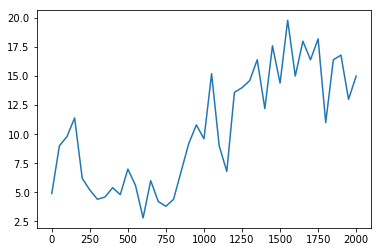

In [22]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [25]:
import os
tmp = GAME_NAME.split('/')[1]
os.mkdir(tmp)
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

In [ ]:
gym.scoreboard.api_key = 'sk_X6PO6hv9Rq24jaL21xROSA'
#gym.upload('/home/ubuntu/records')

In [26]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

In [29]:
save(qvalues_layer,"dist_weights/line_saved_qvalues_layer")

In [ ]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets